# Re-train the model


In this notebook, the model will be retrained daily using the sensor values from the previous day and the actual measured furnace temperature at the end of that day. These new data points will be added to the historical dataset, allowing the model to continuously improve its predictions based on the most recent information. By updating the model regularly, we aim to refine its accuracy over time.

Once the model has been retrained, the two new measurements from the factory sensors for the current day will be injected into the model to predict the optimal furnace temperature by the end of the day. To verify the model's accuracy, the predicted value will be compared to the actual measured temperature at the end of the day, providing a basis for assessing the precision and reliability of the predictions.

In [ ]:
# Install the model packages
# ==============================================================================
!pip install skforecast lightgbm feature-engine onnxmltools

In [13]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from feature_engine.timeseries.forecasting import WindowFeatures
from feature_engine.timeseries.forecasting import LagFeatures
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

# Plots
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# ONNX imports
# ==============================================================================
import os
import onnx
import onnxmltools
from onnxmltools.convert import convert_lightgbm
from onnxmltools.utils import save_model
from skl2onnx.common.data_types import FloatTensorType

In [3]:
# Load historical data
# ==============================================================================
data = pd.read_csv('data/historical.csv')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

In [4]:
# Select the number of days we want to validate for
# ==============================================================================
steps = 7

Train dates : 1992-04-01 00:00:00 --- 2004-11-01 00:00:00  (n=152)
Test dates  : 2004-12-01 00:00:00 --- 2005-06-01 00:00:00  (n=7)


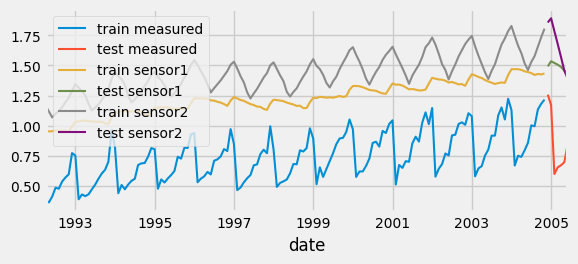

In [5]:
# Split historical data into train-test
# ==============================================================================
data_train = data[:-steps]
data_test = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train measured')
data_test['y'].plot(ax=ax, label='test measured')
data_train['exog_1'].plot(ax=ax, label='train sensor1')
data_test['exog_1'].plot(ax=ax, label='test sensor1')
data_train['exog_2'].plot(ax=ax, label='train sensor2')
data_test['exog_2'].plot(ax=ax, label='test sensor2')
ax.legend(loc='upper left');

In [31]:
# Training the model with train data
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1), lags = 12)

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])

In [33]:
# Train the model with the optimal values
# ==============================================================================
forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])

In [34]:
# Validation
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

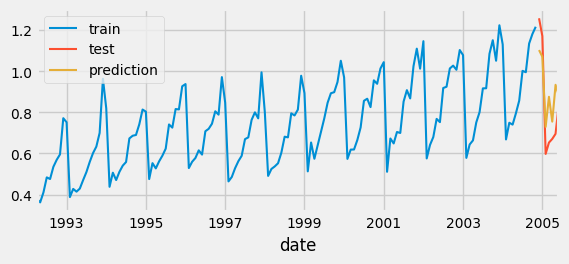

In [35]:
# Plot Validation
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='prediction')
ax.legend();

In [36]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.023758924823257917


In [37]:
# Save the model
# ==============================================================================
regressor = forecaster.regressor

# Define the entry type for ONNX
initial_type = [('float_input', FloatTensorType([None, 2]))]

# Convert the model from LightGBM to ONNX
onnx_model = convert_lightgbm(regressor, name="LGBMRegressor", initial_types=initial_type)

# Save the onnx model
os.makedirs("models/edge/1", exist_ok=True)
save_model(onnx_model, "models/edge/1/model.onnx")

The maximum opset needed by this model is only 8.
